In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
from scipy.stats import chi2_contingency
from src.geo_utils import find_coordinates, calculate_distance

## Data Import

In [2]:
ds_names = ["checkouts", "customers", "libraries", "books"]
data = {name: pd.read_csv(f'../data/preprocessed_{name}.csv') for name in ds_names}

### Collect Geographical Data
The idea is to use geopy package to collect the longitude and latitude coordinates of the libraries and customer's addresses.

One request takes ~1s and delay between two requests is set to 1s to prevent blocking. Dataset needs 2018 requests. The process takes ~35min. The second cell can be used to import already collected data.

In [3]:
# find latitude and longitude for libraries and customers
# for ds_name in ["libraries", "customers"]:
#     data[ds_name][f"coordinates_{ds_name}"] = data[ds_name].apply(
#         lambda x: find_coordinates(
#             address=x["street_address"],
#             city=x["city"],
#             state=x["state"],
#             postal_code=str(x["postal_code"])
#         ),
#         axis=1
#     )
#     data[ds_name].drop(["street_address", "city", "state", "postal_code"], axis=1, inplace=True)
#     data[ds_name].to_csv(f"../data/{ds_name}_coordinates.csv", index=False)

In [3]:
for key in ["customers", "libraries"]:
    data[key] = pd.read_csv(f"../data/{key}_coordinates.csv")
    # convert coordinates from string to list of floats
    data[key][f"coordinates_{key}"] = data[key][f"coordinates_{key}"].where(data[key][f"coordinates_{key}"].notnull(), "None")
    data[key][f"coordinates_{key}"] = data[key][f"coordinates_{key}"].apply(literal_eval)

### Merge Books, Customers and Libraries to Checkouts

In [4]:
checkouts = data["checkouts"].merge(data["customers"], how="left", left_on="patron_id", right_on="id")
checkouts.drop(["id_y", "patron_id", "name"], axis=1, inplace=True)
checkouts.rename(columns={"id_x": "id"}, inplace=True)

checkouts = checkouts.merge(data["libraries"], how="left", left_on="library_id", right_on="id", suffixes=("", "_library"))
checkouts.drop(["library_id", "id_library"], axis=1, inplace=True)

checkouts = checkouts.merge(data["books"], how="left", left_on="id", right_on="id")
checkouts.drop("id", axis=1, inplace=True)

checkouts.sort_values("date_checkout", inplace=True)

# Explanatory Data Analysis
In this, part I will analyse the data and try to create and evaluate some features. 
###
## Time Features
These features are related to the available timestamps (date_checkout, date_returned, birth_date).
####
### Borrowing duration
The main parameter and indicator is the days count between checkout and book return. The threshold of 28 days will be used to create labels with the following categories:
1. "on time" (<=28)
2. "not on time" (>28)
3. "unknown" (missing data)

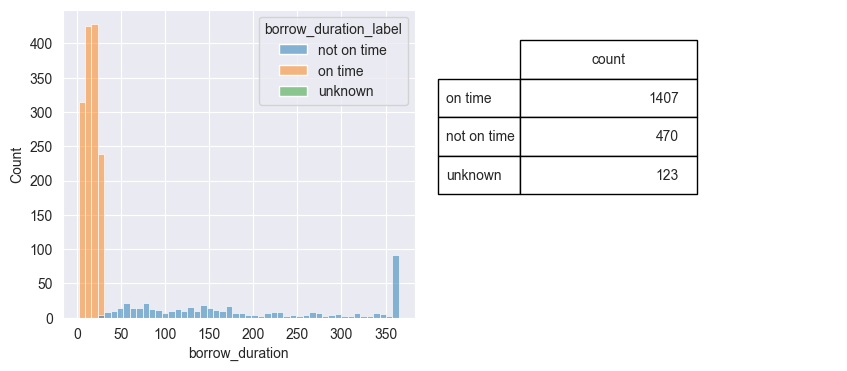

In [5]:
# calculate how long a book was borrowed
checkouts["borrow_duration"] = (
        pd.to_datetime(checkouts["date_returned"]) -
        pd.to_datetime(checkouts["date_checkout"])
).dt.days.abs()

# create label was a book returned on time, not on time ot the status is unknown
borrow_threshold = 28
checkouts["borrow_duration_label"] = "unknown"
checkouts.loc[checkouts["borrow_duration"] > borrow_threshold, "borrow_duration_label"] = "not on time"
checkouts.loc[checkouts["borrow_duration"] <= borrow_threshold, "borrow_duration_label"] = "on time"

# plot histogram and show label counts
label_counts = checkouts["borrow_duration_label"].value_counts().to_frame()
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.histplot(data=checkouts, x="borrow_duration", hue="borrow_duration_label",  bins=50, ax=axs[0])
axs[1].axis('off')
mpl_table = axs[1].table(cellText = label_counts.values, rowLabels = label_counts.index,
                         bbox=[0.1, 0.4, 0.5, 0.5], colLabels=label_counts.columns)

The histogram shows that the population of customers who don't return books on time tends to have a uniform distribution.
###
### Borrow Count
This feature should provide the basic insight into book's history. 

Correlation not_on_time_count_relative vs borrow_duration: 0.6268566130376858


<Axes: xlabel='not_on_time_count_relative'>

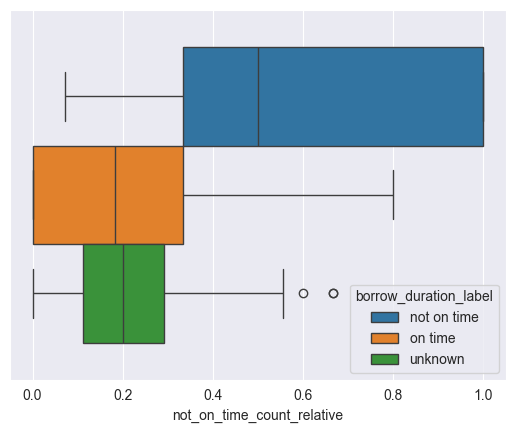

In [41]:
checkouts["borrow_count"] = checkouts.groupby("title").cumcount() + 1
checkouts["not_on_time"] = checkouts["borrow_duration_label"] == "not on time"
checkouts["not_on_time_count"] = checkouts.groupby("title")["not_on_time"].cumsum()
checkouts["not_on_time_count_relative"] = checkouts["not_on_time_count"] / checkouts["borrow_count"]

correlation = float(checkouts["not_on_time_count_relative"].corr(checkouts["borrow_duration"]))
print(f"Correlation not_on_time_count_relative vs borrow_duration: {correlation}")

sns.boxplot(data=checkouts, x="not_on_time_count_relative", hue="borrow_duration_label")

The ratio of number of not on time returns and total number of borrows correlates with the labels, but due to its direct link with the target it potentially can force the model to overfit or excessive dependence on this feature. Therefore, this historical insight should be more generalised and defined as books features (how often a book is not returned on time, etc.)

Correlation not_on_time_rate vs borrow_duration: 0.291608647558271


<Axes: xlabel='not_on_time_rate'>

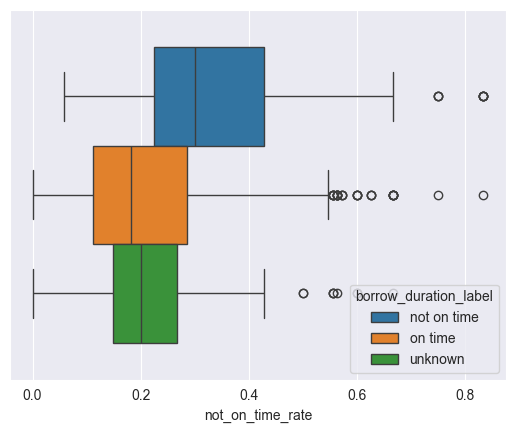

In [92]:
checkouts["not_on_time"] = checkouts["borrow_duration_label"] == "not on time"
not_on_time_rate = checkouts.groupby("title")["not_on_time"].sum() / checkouts["title"].value_counts()
not_on_time_rate.name = "not_on_time_rate"
not_on_time_rate = not_on_time_rate.to_frame()
checkouts = checkouts.merge(not_on_time_rate, how="left", left_on="title", right_on="title")

correlation = float(checkouts["not_on_time_rate"].corr(checkouts["borrow_duration"]))
print(f"Correlation not_on_time_rate vs borrow_duration: {correlation}")

sns.boxplot(data=checkouts, x="not_on_time_rate", hue="borrow_duration_label")


###
### Seasons
I want to check if part of the year (quarter or season) influences prolonged book borrowing.

In [43]:
# Seasons
date = pd.to_datetime(checkouts["date_checkout"])
checkouts["quarter"] = pd.cut(date.dt.month, bins=[0, 3, 6, 9, 12], labels=["Q1", "Q2", "Q3", "Q4"])
days = (date.dt.month*100 + date.dt.day - 130)%1300
checkouts["season"] = pd.cut(days, bins=[0, 300, 602, 900, 1300], labels=['spring', 'summer', 'autumn', 'winter'])

contingency_season = pd.crosstab(checkouts["season"], checkouts["borrow_duration_label"])
chi2_season, p_season, dof_season, expected_season = chi2_contingency(contingency_season)

contingency_quarter = pd.crosstab(checkouts["quarter"], checkouts["borrow_duration_label"])
chi2_quarter, p_quarter, dof_quarter, expected_quarter = chi2_contingency(contingency_quarter)

print(f"Season - Chi2: {chi2_season}, p-value: {p_season}\nQuarter - Chi2: {chi2_quarter}, p-value: {p_quarter}")
pd.crosstab(checkouts["season"], checkouts["borrow_duration_label"])

Season - Chi2: 3.6890923711238077, p-value: 0.7186651654900678
Quarter - Chi2: 3.1757568450108438, p-value: 0.7864862376476867


borrow_duration_label,not on time,on time,unknown
season,,,
spring,120,356,15
summer,107,375,15
autumn,119,311,13
winter,121,360,15


Due to high p values (>0.05), these parameters can be considered as not highly correlated with the label. Additionally, visual inspection of the crosstab indicates an almost even distribution between categories.
###
### Customer's Age
I want to calculate the customer's age at the moment of book borrowing.

In [44]:
# Customers age in the moment of a checkout
checkouts["customers_age"] = (
        pd.to_datetime(checkouts["date_checkout"]).dt.year -
        pd.to_datetime(checkouts["birth_date"]).dt.year
).abs()
checkouts.drop(["date_checkout", "date_returned", "birth_date"], axis=1, inplace=True)

correlation = float(checkouts["customers_age"].corr(checkouts["borrow_duration"]))
print(f"Correlation customers_age vs borrow_duration: {correlation}")

Correlation customers_age vs borrow_duration: -0.0042989246951765925



Customer's age and borrowing duration are not highly correlated.
###
### Geographical Features
Using longitude and latitude coordinates I want to calculate distances between libraries and customers. For that purpose I will use Haversine formula.

Correlation distance vs borrow_duration: 0.12073322519689159


<Axes: xlabel='distance', ylabel='name'>

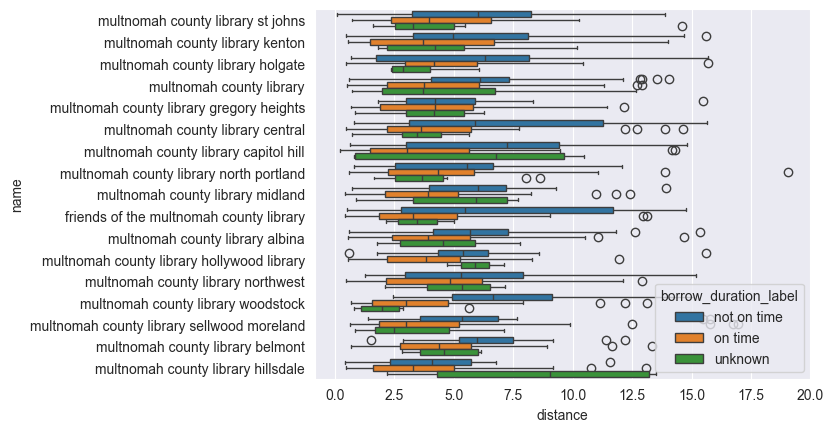

In [45]:
checkouts["distance"] = checkouts.apply(lambda row: calculate_distance(loc1=row["coordinates_libraries"], loc2=row["coordinates_customers"]), axis=1)
checkouts.drop(["coordinates_libraries", "coordinates_customers"], axis=1, inplace=True)

correlation = float(checkouts["distance"].corr(checkouts["borrow_duration"]))
print(f"Correlation distance vs borrow_duration: {correlation}")

sns.boxplot(data=checkouts, x="distance", y="name", hue="borrow_duration_label")

 The correlation is not so high for the whole dataset, but some subsets probably correlate. The boxplot shows that for some libraries, "not on time" labels have average higher distances than the others.
###
### Other Customer's Characteristics
 The other categorical parameters (education, occupation, gender) could be useful in defining specific subsets. Maybe some specific customer profile tends to keep a book longer. 

In [46]:
pd.crosstab([checkouts["occupation"], checkouts["education"], checkouts["gender"]], checkouts["borrow_duration_label"])

borrow_duration_label               not on time  on time  unknown
occupation education       gender                                
admin      college         female             4       20        4
                           male              20       41        2
                           unknown            0        1        0
           graduate degree female            13       39        8
                           male               9       23        1
...                                         ...      ...      ...
tech       high school     male              14       31        1
                           unknown            1        0        0
           others          female             9       21        0
                           male               7       19        2
                           unknown            0        1        0

[82 rows x 3 columns]

<Axes: xlabel='occupation', ylabel='distance'>

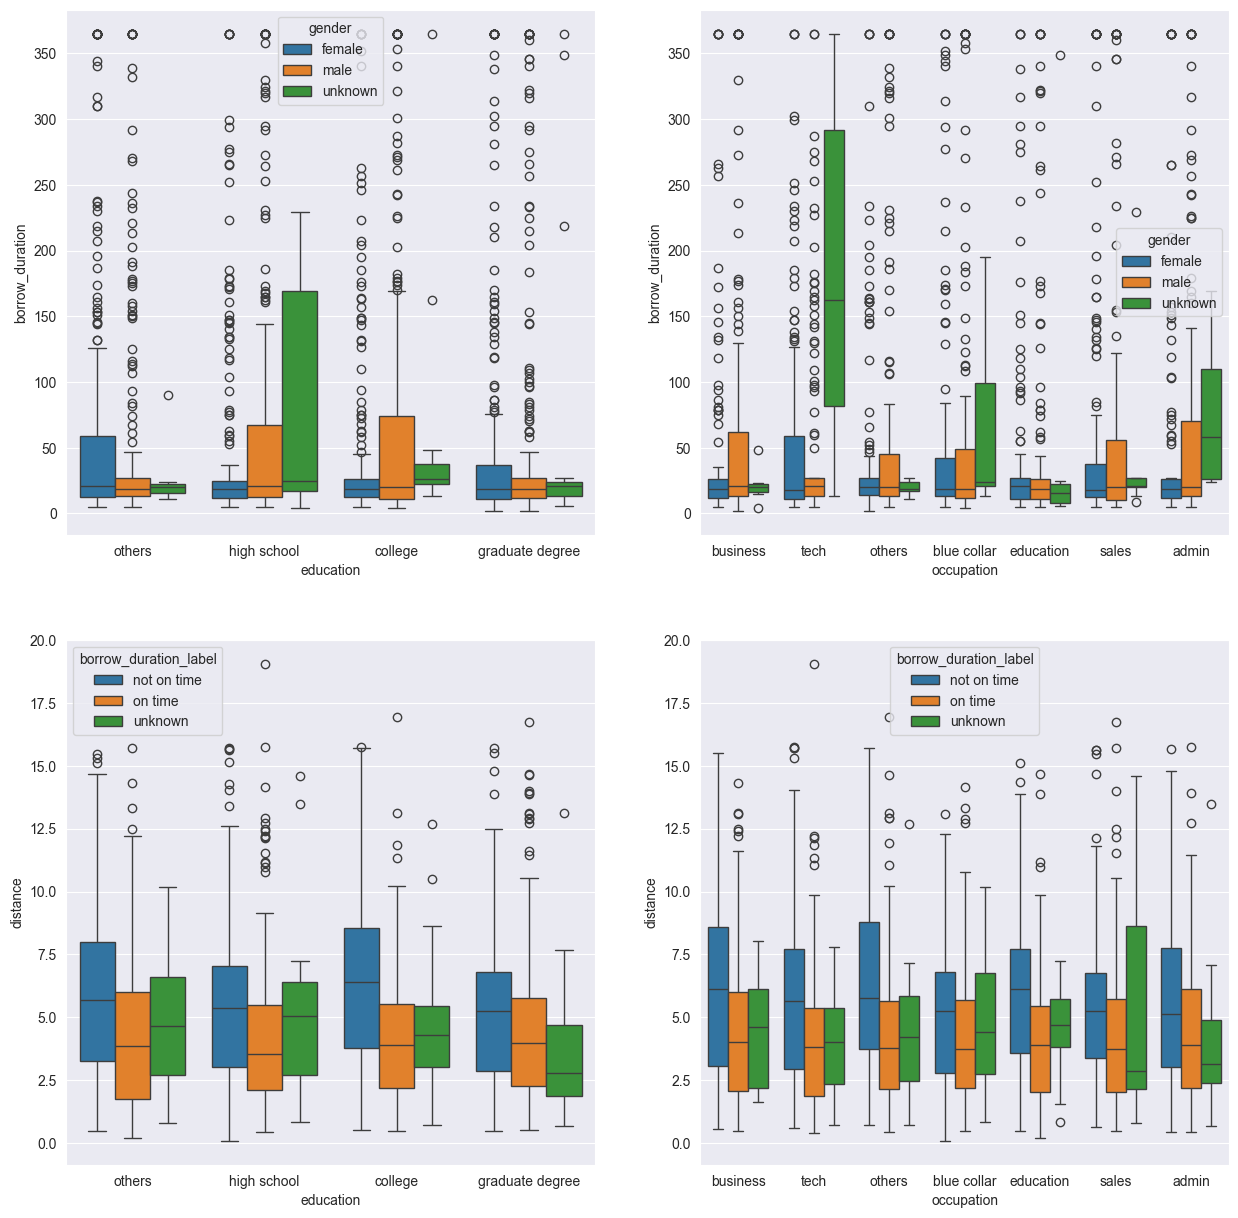

In [47]:
fig_3, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
sns.boxplot(data=checkouts, x="education", y="borrow_duration", hue="gender", ax=axs[0, 0])
sns.boxplot(data=checkouts, x="occupation", y="borrow_duration", hue="gender", ax=axs[0, 1])
sns.boxplot(data=checkouts, x="education", y="distance", hue="borrow_duration_label", ax=axs[1, 0])
sns.boxplot(data=checkouts, x="occupation", y="distance", hue="borrow_duration_label", ax=axs[1, 1])

In [48]:
checkouts.groupby(["gender", "occupation", "education", "season"], observed=False)[["customers_age", "distance", "borrow_duration"]].corr()

customers_age  \
gender  occupation education   season                                  
female  admin      college     spring customers_age         1.000000   
                                      distance             -0.435468   
                                      borrow_duration      -0.141964   
                               summer customers_age         1.000000   
                                      distance             -0.780798   
...                                                              ...   
unknown tech       high school winter distance                   NaN   
                                      borrow_duration            NaN   
                   others      spring customers_age              NaN   
                                      distance                   NaN   
                                      borrow_duration            NaN   

                                                       distance  \
gender  occupation education   season                             
female  admin      college     spring customers_age   -0.435468   
                                      distance         1.000000   
                                      borrow_duration  0.137626   
                               summer customers_age   -0.780798   
                                      distance         1.000000   
...                                                         ...   
unknown tech       high school winter distance              NaN   
                                      borrow_duration       NaN   
                   others      spring customers_age         NaN   
                                      distance              NaN   
                                      borrow_duration       NaN   

                                                       borrow_duration  
gender  occupation education   season                                   
female  admin      college     spring customers_age          -0.141964  
                                      distance                0.137626  
                                      borrow_duration         1.000000  
                               summer customers_age           0.010010  
                                      distance                0.242750  
...                                                                ...  
unknown tech       high school winter distance                     NaN  
                                      borrow_duration              NaN  
                   others      spring customers_age                NaN  
                                      distance                     NaN  
                                      borrow_duration              NaN  

[792 rows x 3 columns]

Although individual parameters don't correlate significantly with borrow duration (or its label), certain combinations of the parameters have a higher correlation index.
###
### Book Parameters
###


Correlation price vs borrow_duration: 0.039503009017211724
Correlation price vs pages: 0.7410743481002869


<Axes: xlabel='price', ylabel='Count'>

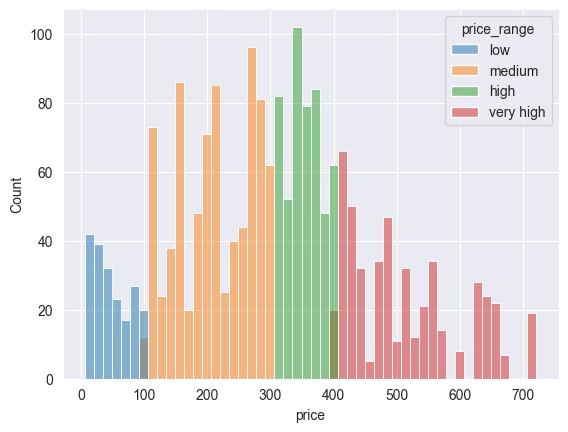

In [97]:
checkouts["price_range"] = pd.qcut(checkouts["price"], q=[0, 0.1, 0.5, 0.75, 1], labels=["low", "medium", "high", "very high"])
checkouts["pages_range"] = pd.qcut(checkouts["pages"], q=[0, 0.1, 0.5, 0.75, 1], labels=["small", "medium", "large", "very large"])

correlation = float(checkouts["price"].corr(checkouts["borrow_duration"]))
print(f"Correlation price vs borrow_duration: {correlation}")

correlation = float(checkouts["price"].corr(checkouts["pages"]))
print(f"Correlation price vs pages: {correlation}")

sns.histplot(data=checkouts, x="price", hue="price_range", bins=50)

In [98]:
checkouts.groupby("categories")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
categories,,,,,,,,
advertising,313.0,330.148083,127.798528,25.50,240.99,361.99,420.99,536.99
engines,439.0,275.359043,161.978421,11.50,150.99,274.99,388.00,647.99
financial,251.0,301.263825,149.508417,14.00,233.00,282.50,354.50,650.99
government publication,356.0,341.402275,161.465107,31.00,207.50,364.99,432.50,707.99
mechanics,292.0,314.202260,174.618536,5.99,200.99,305.99,396.99,721.00
medicine,349.0,275.923725,152.514467,21.50,149.99,290.50,347.00,648.00


In [99]:
checkouts.groupby("categories")["pages"].describe()

,count,mean,std,min,25%,50%,75%,max
categories,,,,,,,,
advertising,313.0,612.070288,146.333506,320.0,526.0,635.0,720.0,859.0
engines,439.0,571.712984,179.312575,236.0,416.0,572.0,697.5,932.0
financial,251.0,631.689243,188.214535,353.0,497.0,596.0,752.0,967.0
government publication,356.0,634.553371,162.704606,322.0,530.0,616.0,748.0,1154.0
mechanics,292.0,554.047945,154.325907,305.0,442.0,512.0,658.0,925.0
medicine,349.0,544.441261,156.226681,124.0,410.0,578.0,621.0,900.0


In [101]:
pd.crosstab(checkouts["price_range"], checkouts["pages_range"])

pages_range,small,medium,large,very large
price_range,,,,
low,132,58,10,0
medium,79,509,150,67
high,0,148,216,145
very high,0,77,122,287


Prices and number of pages are highly correlated, and nether of them is not correlated to the borrowing period.

# Final Set Preparation



In [103]:
final_set = checkouts[[
    'gender',
    'education',
    'occupation',
    "not_on_time_rate",
    "borrow_duration",
    'borrow_duration_label',
    'distance',
    'price_range',
    'pages_range',
    'season',
    'name',
]].dropna()
final_set.to_csv("../data/final_set.csv", index=False)